In [1]:
# Create directories
# Creating Train / Val / Test folders (One time use)
import os
import numpy as np
import shutil

# Set dirs and classes
root_dir = './raw_dataset/' # data root path
new_dir = './Dataset/'
classes_dir = ['Basalt', 'Coal', 'Granite', 'Limestone', 'Marble', 'Quartzite', 'Sandstone'] #total labels

# Parameters
val_ratio = 0.15
test_ratio = 0.05

# Create dirs
try:
       for cls in classes_dir:
              os.makedirs(new_dir +'train/' + cls)
              os.makedirs(new_dir +'val/' + cls)
              os.makedirs(new_dir +'test/' + cls)

              # Creating partitions of the data after shuffeling
              src = root_dir + cls # Folder to copy images from

              allFileNames = os.listdir(src)
              np.random.shuffle(allFileNames) # Randomize

              # Train test split
              train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                      [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                                      int(len(allFileNames)* (1 - test_ratio))])

              # Get all names
              train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
              val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
              test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

              print('Total images: ', len(allFileNames))
              print('Training: ', len(train_FileNames))
              print('Validation: ', len(val_FileNames))
              print('Testing: ', len(test_FileNames))

              # Copy-pasting images
              for name in train_FileNames:
                     shutil.copy(name, new_dir +'train/' + cls)

              for name in val_FileNames:
                     shutil.copy(name, new_dir +'val/' + cls)

              for name in test_FileNames:
                     shutil.copy(name, new_dir +'test/' + cls)
except:
       pass

In [2]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt


#train and test data directory
data_dir = "./Dataset/train"
test_data_dir = "./Dataset/test"


#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

/Users/enjuichang/VSProject/classy-rock/classy_rock/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Validation and exploration
img, label = dataset[0]
print(img.shape,label)
print("Follwing classes are there : \n",dataset.classes)

torch.Size([3, 150, 150]) 0
Follwing classes are there : 
 ['Basalt', 'Coal', 'Granite', 'Limestone', 'Marble', 'Quartzite', 'Sandstone']


Label : Basalt


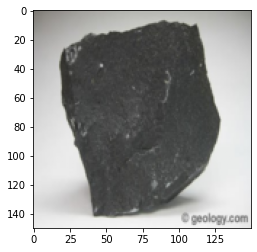

In [4]:
# Display image
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[0])

In [5]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_size = 2000
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 12034
#Length of Validation Data : 2000

#load the train and validation into batches.
multiprocessing_context=torch.multiprocessing.get_context('spawn')
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True, multiprocessing_context=multiprocessing_context)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True, multiprocessing_context=multiprocessing_context)

Length of Train Data : 1316
Length of Validation Data : 342


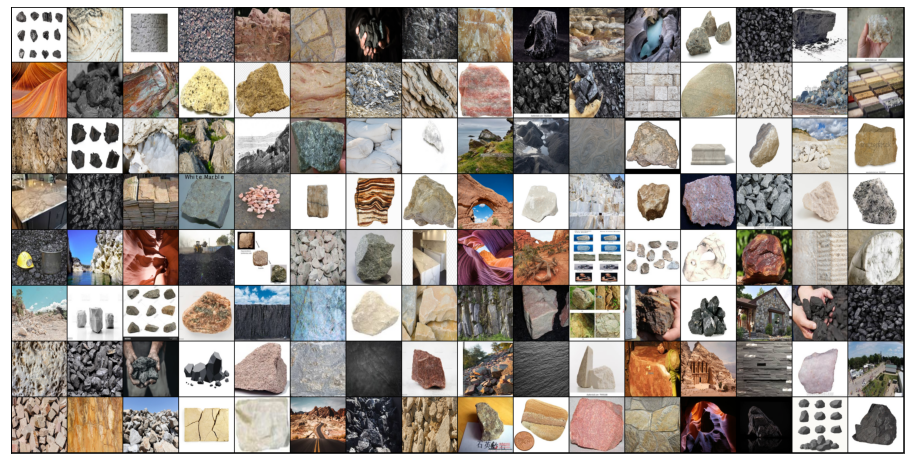

In [6]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:

class RockClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,7)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [16]:
cls = RockClassification()

num_epochs = 2
opt_func = torch.optim.Adam
lr = 0.001
model = cls

#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    

plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)